In [131]:
#Import necessary libraries, modules

import os
import requests
import json
import pandas as pd
import hvplot.pandas
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [132]:
load_dotenv()

True

In [133]:
# Retrieve API keys for Alpaca
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [134]:
# Create REST object for Alpaca calls
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [135]:
#Perform set up for baseline Monte Carlo analysis for SPY
spy_baseline_ticker = ["SPY"]
stock_timeframe = "1Day"
stock_start_date = pd.Timestamp("2017-05-11", tz="America/New_York").isoformat()
stock_end_date = pd.Timestamp("2022-05-11", tz="America/New_York").isoformat()

spy_baseline_df = alpaca.get_bars(
    spy_baseline_ticker,
    stock_timeframe,
    start=stock_start_date,
    end=stock_end_date
).df

#Strip timestamp and leave only the date as the index
spy_baseline_df.index = spy_baseline_df.index.date

# Create multi-level dataframe for MCSimulation call
SPY = pd.concat([spy_baseline_df], axis = 1, keys=['SPY'])

In [136]:
# Configure baseline Monte Carlo simulation to forecast 20 years cumulative returns
MC_spy_baseline = MCSimulation(
    portfolio_data = SPY,
    weights = [1],
    num_simulation = 100,
    num_trading_days = 252*20
)

# Review the simulation input data
MC_spy_baseline.portfolio_data.head()

SPY                                                   \
              open      high     low   close     volume trade_count   
2017-05-11  239.31  239.5700  238.13  239.38   62269354      211029   
2017-05-12  239.05  239.4273  238.67  238.98   53912730      158255   
2017-05-15  239.49  240.4400  239.45  240.30   61868937      193291   
2017-05-16  240.64  240.6700  239.63  240.08   51241791      183988   
2017-05-17  238.09  238.6400  235.75  235.82  172174107      523471   

                                            
                  vwap symbol daily_return  
2017-05-11  239.088106    SPY          NaN  
2017-05-12  239.000514    SPY    -0.001671  
2017-05-15  240.042085    SPY     0.005523  
2017-05-16  240.104677    SPY    -0.000916  
2017-05-17  237.387451    SPY    -0.017744

In [137]:
test2_df = MC_spy_baseline.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


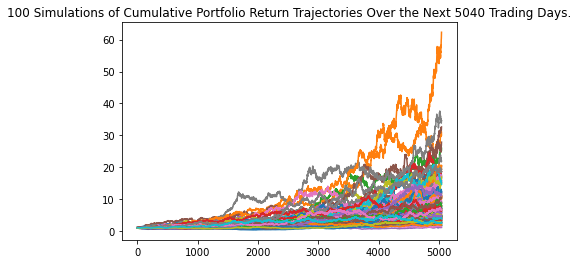

In [138]:
MC_line_plot = MC_spy_baseline.plot_simulation()

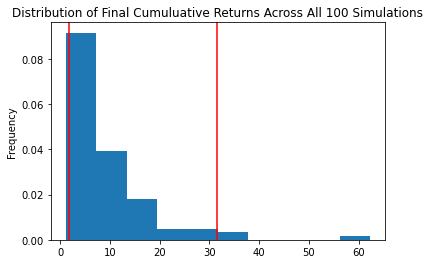

In [139]:
MC_histo_plot = MC_spy_baseline.plot_distribution()

In [140]:
# Generate SPY summary statistics from the 20-year Monte Carlo simulation
MC_summary_stats = MC_spy_baseline.summarize_cumulative_return()

# Review the 20-year Monte Carlo summary statistics
display(MC_summary_stats)

count           100.000000
mean              9.373413
std               8.858866
min               1.107589
25%               3.981631
50%               6.569836
75%              11.402973
max              62.304207
95% CI Lower      1.714219
95% CI Upper     31.413798
Name: 5040, dtype: float64

In [141]:
#Set up data for alpaca get_crypto_bars function call for crypto tokens
crypto_ticker = ["BTCUSD", "ETHUSD"]
crypto_timeframe = "1Day"
crypto_start_date = pd.Timestamp("2017-01-31", tz="America/New_York").isoformat()
crypto_end_date = pd.Timestamp("2022-03-31", tz="America/New_York").isoformat()

In [142]:
#Alpaca call to retrieve crypto data for tickers in crypto_ticker
crypto_closing_prices = alpaca.get_crypto_bars(
    crypto_ticker,
    crypto_timeframe,
    start=crypto_start_date,
    end=crypto_end_date
).df

#Strip timestamp and leave only the date as the index
crypto_closing_prices.index = crypto_closing_prices.index.date

In [143]:
#Set up data for alpaca get_bars function call for stocks
stock_ticker = ["SHEL", "XOM", "AMZN", "TSLA", "AAPL", "RLGY", "FCEL", "CLNE", "MYRG", "SOFI", "FSM"]
stock_timeframe = "1Day"
stock_start_date = pd.Timestamp("2017-01-31", tz="America/New_York").isoformat()
stock_end_date = pd.Timestamp("2022-03-31", tz="America/New_York").isoformat()

In [144]:
#Alpaca call to retrieve data for tickers in stock_ticker
stock_closing_prices = alpaca.get_bars(
    stock_ticker,
    stock_timeframe,
    start=stock_start_date,
    end=stock_end_date
).df

#Strip timestamp and leave only the date as the index
stock_closing_prices.index = stock_closing_prices.index.date


In [150]:
def create_combined_df_list(crypto_ticker, stock_ticker):
    
    combined_df_list = []
    
    for ticker in crypto_ticker:
        ticker = crypto_closing_prices[crypto_closing_prices["symbol"] == 
            ticker].drop(["exchange", "open", "high", "low", "volume", "trade_count", "vwap", "symbol"], axis=1)
        ticker = ticker[~ticker.index.duplicated(keep='first')]
        combined_df_list.append(ticker)
    
    for ticker in stock_ticker:
        ticker = stock_closing_prices[stock_closing_prices["symbol"] == 
            ticker].drop(["open", "high", "low", "volume", "trade_count", "vwap", "symbol"], axis=1)
        combined_df_list.append(ticker)

    return combined_df_list

In [151]:
combined_ticker_list = crypto_ticker + stock_ticker
combined_df = pd.concat(create_combined_df_list(crypto_ticker, stock_ticker), axis=1, 
                        keys=combined_ticker_list)
combined_df = combined_df.dropna()
combined_df.head()

,BTCUSD,ETHUSD,SHEL,XOM,AMZN,TSLA,AAPL,RLGY,FCEL,CLNE,MYRG,SOFI,FSM
,close,close,close,close,close,close,close,close,close,close,close,close,close
2022-02-01,38429.17,2764.79,52.68,80.83,3023.87,931.25,174.61,16.36,4.46,6.34,94.90,13.27,3.52
2022-02-02,37019.84,2656.80,53.25,80.62,3012.25,905.66,175.84,16.28,4.19,6.03,92.57,12.16,3.42
2022-02-03,37566.75,2771.99,53.91,79.68,2776.91,891.14,172.90,16.13,4.07,5.86,90.75,11.57,3.30
2022-02-04,41557.54,3027.24,55.10,81.41,3152.79,923.32,172.39,16.46,4.28,6.00,90.17,11.89,3.24
2022-02-07,44916.93,3187.58,55.71,82.39,3158.71,907.34,171.66,16.45,4.37,6.20,91.02,11.72,3.50


In [147]:
# Configure the Monte Carlo simulation to forecast X years cumulative returns

MC_five_year = MCSimulation(
    portfolio_data = combined_df,
    weights = [.15, .15, .15, .15, .20, .04, .04, .04, .02, .02, .02, .01, .01],
    num_simulation = 100,
    num_trading_days = 252*20
)

# Review the simulation input data
MC_five_year.portfolio_data.tail()

BTCUSD                ETHUSD                SHEL               \
               close daily_return    close daily_return  close daily_return   
2022-03-24  44116.67     0.027585  3146.32     0.039038  55.02     0.005115   
2022-03-25  44433.32     0.007178  3113.85    -0.010320  55.59     0.010360   
2022-03-28  47624.51     0.071820  3391.14     0.089051  53.98    -0.028962   
2022-03-29  47255.62    -0.007746  3373.30    -0.005261  53.45    -0.009818   
2022-03-30  47031.64    -0.004740  3391.53     0.005404  55.61     0.040412   

              XOM                  AMZN               ...  FCEL               \
            close daily_return    close daily_return  ... close daily_return   
2022-03-24  83.38     0.003007  3272.99     0.001478  ...  6.62     0.007610   
2022-03-25  85.20     0.021828  3295.47     0.006868  ...  6.22    -0.060423   
2022-03-28  82.81    -0.028052  3379.81     0.025593  ...  6.11    -0.017685   
2022-03-29  82.37    -0.005313  3386.30     0.001920  ...  6.24     0.021277   
2022-03-30  83.78     0.017118  3326.02    -0.017801  ...  5.87    -0.059295   

            CLNE                MYRG                SOFI                FSM  \
           close daily_return  close daily_return  close daily_return close   
2022-03-24  7.77     0.007782  99.63     0.004132   9.47     0.010672  3.90   
2022-03-25  7.92     0.019305  99.78     0.001506   9.01    -0.048574  3.84   
2022-03-28  7.69    -0.029040  97.50    -0.022850   9.25     0.026637  3.70   
2022-03-29  7.88     0.024707  97.14    -0.003692  10.14     0.096216  3.83   
2022-03-30  7.99     0.013959  95.55    -0.016368   9.77    -0.036489  3.84   

                         
           daily_return  
2022-03-24    -0.064748  
2022-03-25    -0.015385  
2022-03-28    -0.036458  
2022-03-29     0.035135  
2022-03-30     0.002611  

[5 rows x 26 columns]

In [148]:
test_df = MC_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


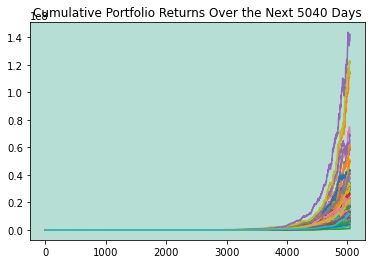

In [127]:
plot = test_df.plot(
    legend=False,
    title='Cumulative Portfolio Returns Over the Next 5040 Days',
)

plot.set_facecolor('#B7DED5')

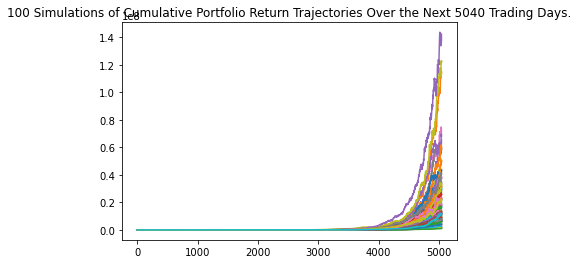

In [128]:
MC_line_plot = MC_five_year.plot_simulation()

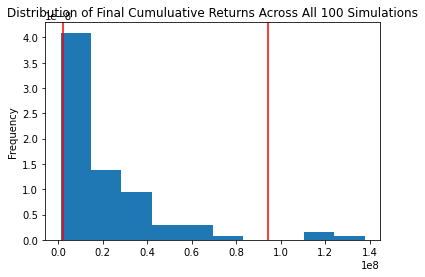

In [129]:
MC_histo_plot = MC_five_year.plot_distribution()

In [130]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
MC_summary_stats = MC_five_year.summarize_cumulative_return()


# Review the 30-year Monte Carlo summary statistics
display(MC_summary_stats)

count           1.000000e+02
mean            2.163962e+07
std             2.416602e+07
min             9.968277e+05
25%             7.561498e+06
50%             1.213467e+07
75%             2.792715e+07
max             1.377699e+08
95% CI Lower    1.918635e+06
95% CI Upper    9.409520e+07
Name: 5040, dtype: float64